In [1]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

C:\Users\akash\cuda_installation_sample\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Random Seed:  999


In [2]:
workers = 2
batch_size = 384
image_size = 64
num_epochs = 5
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

ngpu = 1

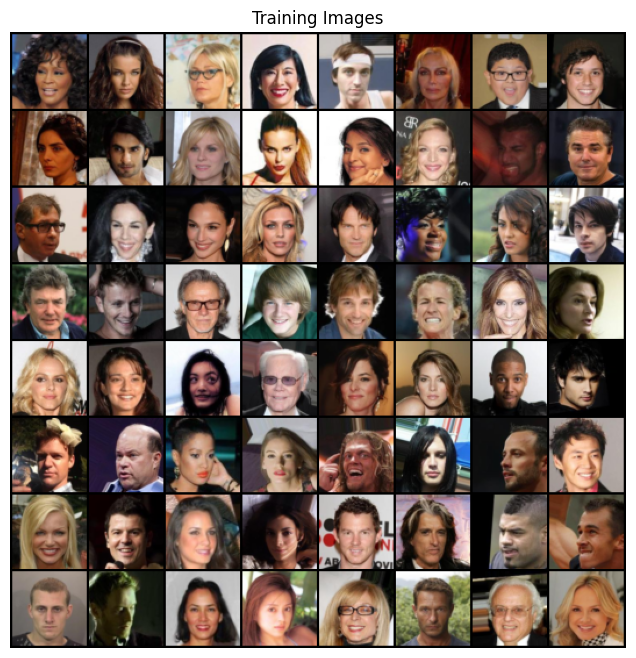

In [3]:

path='celeb/img_align_celeba'
dataset = datasets.ImageFolder(root=path,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5,0.5),(0.5, 0.5,0.5))
                           ]))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

#Training Images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
# custom weights initialization called on gen and disc
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [5]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
           
            nn.ConvTranspose2d( 100, 64*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.ConvTranspose2d( 64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( 64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Dropout(0.1),
            
            nn.ConvTranspose2d( 64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            
        )

    def forward(self, input):
        return self.main(input)

In [6]:

gen = Generator(ngpu).to(device)
# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    gen = nn.DataParallel(gen, list(range(ngpu)))
#apply weights
gen.apply(weights_init)
print(gen)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Dropout(p=0.2, inplace=False)
    (7): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Dropout(p=0.1, inplace=False)
    (14): ConvTranspose2d(64, 3, kernel

In [7]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [8]:
disc = Discriminator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    disc = nn.DataParallel(disc, list(range(ngpu)))
disc.apply(weights_init)
print(disc)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [9]:

criterion = nn.BCELoss()
fixed_noise = torch.randn(64, 100, 1, 1, device=device)
real_label = 1.
fake_label = 0.
optimizerD = optim.Adam(disc.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(gen.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop


img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

for epoch in range(num_epochs):
    
    for i, data in enumerate(dataloader, 0):
        # Training Discriminator network: maximize log(D(real)) + log(1 - D(G(z))) 2 nd term is for fake
        disc.zero_grad()
        real = data[0].to(device)
        b_size = real.size(0)
        ones = torch.full((b_size,), real_label, dtype=torch.float, device=device) #log(D(real))
        output = disc(real).view(-1) 
        errD_real = criterion(output, ones)
        D_x = output.mean().item()
        errD_real.backward()
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        fake = gen(noise) #generate the fake images
        ones.fill_(fake_label)  #log(1-D(G(fake)))
        output = disc(fake.detach()).view(-1)
        errD_fake = criterion(output, ones)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # (2) Update G network: maximize log(D(G(z)))
      
        gen.zero_grad()
        ones.fill_(real_label)  #setting one
        output = disc(fake).view(-1)
        errG = criterion(output, ones)
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

       
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/273]	Loss_D: 0.0452	Loss_G: 6.9869	D(x): 0.9750	D(G(z)): 0.0041 / 0.0021
[0/5][50/273]	Loss_D: 0.1517	Loss_G: 17.7359	D(x): 0.9925	D(G(z)): 0.1207 / 0.0000


In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()